# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with an `EstimatorQNN`
    * Classification with a `SamplerQNN`
    * Variational Quantum Classifier (`VQC`)
    
    
2. [Regression](#Regression)
    * Regression with an `EstimatorQNN`
    * Variational Quantum Regressor (`VQR`)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

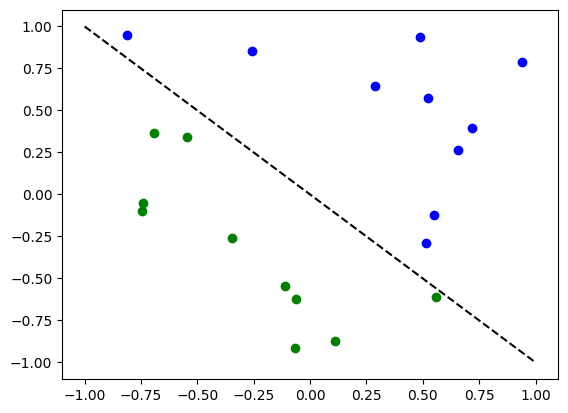

In [2]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
service = QiskitRuntimeService()

In [48]:
sim_session=Session(backend='ibmq_qasm_simulator')
runtime_sampler_simulator = Sampler(session=sim_session)

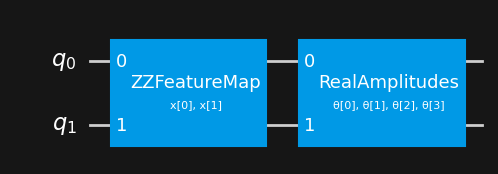

In [4]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [5]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [52]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_simulator
)

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [54]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

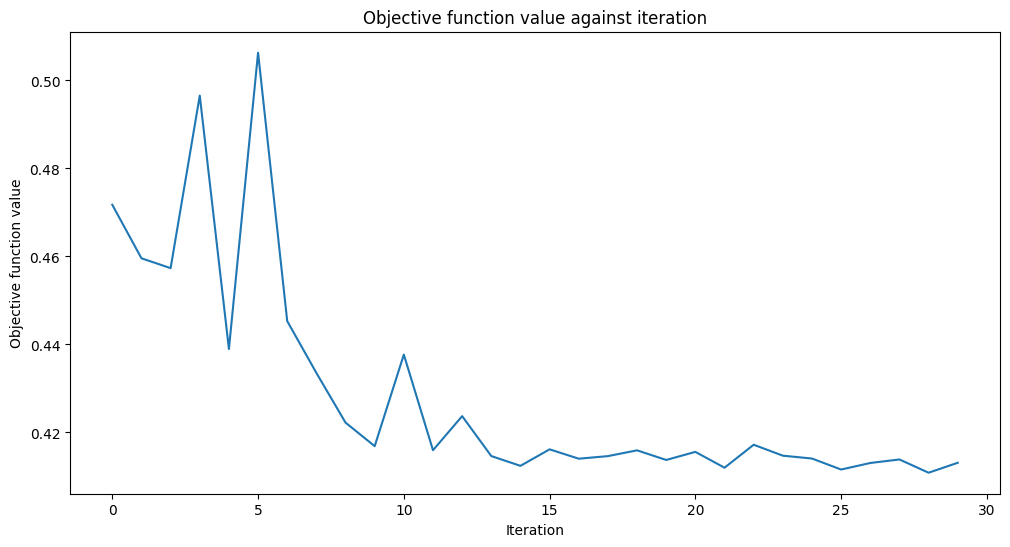

0.8

In [55]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score (Classification: mean accuracy): ",sampler_classifier.score(X, y01))

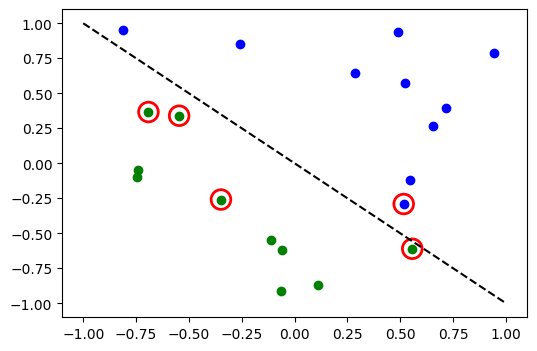

In [33]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Once the model is trained we can take a look at the weights.

In [57]:
sampler_classifier.weights

array([1.87524592, 2.74957179, 0.93023303, 1.792186  ])

### Run on a real QC through Qiskit Runtime

In [6]:
real_qc_session=Session(backend='ibm_peekskill')
runtime_sampler_realQC = Sampler(session=real_qc_session)

In [7]:
sampler_qnn_realQC = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_realQC
)

In [10]:
# construct classifier
sampler_classifier_realQC = NeuralNetworkClassifier(
    neural_network=sampler_qnn_realQC, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

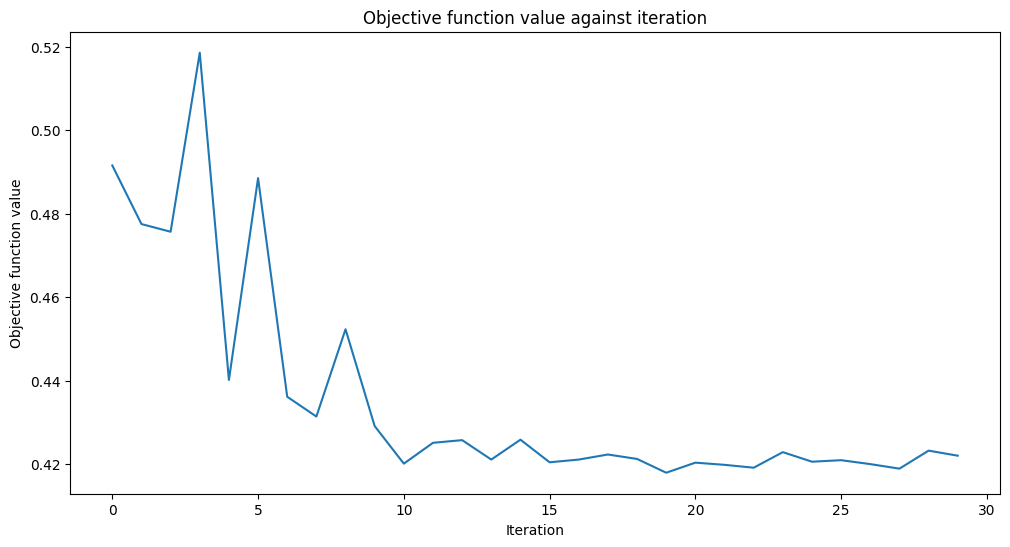

Score (Classification: mean accuracy):  0.75


In [11]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier_realQC.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score (Classification: mean accuracy): ",sampler_classifier_realQC.score(X, y01))

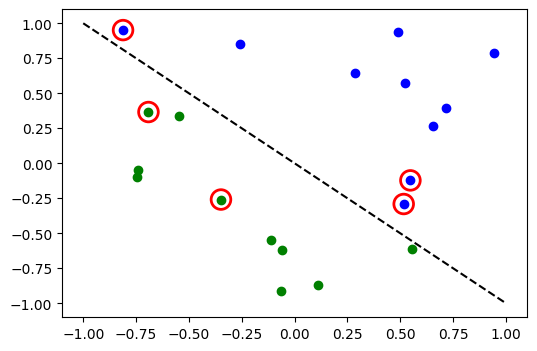

In [12]:
# evaluate data points
y_predict = sampler_classifier_realQC.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [59]:
import qiskit.tools.jupyter

%qiskit_version_table